Hello, dear reader! This is the third notebook in the Spring 2019 MCFAM math of machine learning seminar at the University of Minnesota. Join us in person in Vincent Hall 301, 1:30-2:30 pm, in March 2019.

This notebook addresses logistic regression. Logistic regression is a linear method for binary classification. I think this is funny, because it has 'regression' in the name but is used a lot for classification, and because everyone knows the graph of the sigmoid, which is definitely not linear! So why do we call it a linear method and use it for classification? See below. Also see the uploaded worksheets which lead you through a simple example of logistic regression 'by hand' -- I think it's very illustrative to figure out the basics.


This worksheet is copyleft by Kaisa Taipale, 2019, under the GNU Affero GPL.

In [4]:
# Import all the things
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics

## Basics on logistic regression

Here I'm going to go over what we talked about in person again. This should be useful for people who didn't join us in person, and might be useful for review. This section only discusses binary classification using logistic regression. Moreover, we'll do this in the single-variable case -- one feature variable and one label for each sample.

The *sigmoid* curve used in logistic regression has a long history in ecology, population dynamics, and statistics. 

In [ ]:
# graph the sigmoid

In [1]:
# look, it solves a DE!


Rather than using its ecological interpretation, we'll use it for probability estimation and classification. The sigmoid curve will allow us to assign a probability of being "class 0" or "class 1" in our binary classification. Here's a classic picture, if I can manage it:

In [2]:
# pic of 000 and 111 and curve

We call logistic regression a *linear* method because the part of the model with parameters based on the data is $ \beta_0 + \beta_1 x.$ Solve for $\beta_0 + \beta_1 x$ and notice that what you end up with on the other side of the equation is $\log \frac{p}{1-p}$. We call this the "log odds". Note that I'm being a mathematician and to me $\log$ is base $e$, not base 10 (base 10 is for engineers :) ).


Let's try logistic regression on an expanded version of the worksheet we did in class. In the seminar I asked people to fit a logistic model to predict heart disease based on the single input of resting heart rate, using data I made up inspired by the Cleveland heart disease data set. In the seminar I asked people to "eyeball" a linear regression, a line through the log-odds. With enough nice data, the human eye is pretty decent at fitting a line. We got remarkably consistent results.

Here we can use a bigger list of inputs -- many more resting heart rate readings, as well as other variables! I will again take you step by step through the process of constructing the logistic regression model, and after that we'll skip to scikit-learn's implementation. Go to https://archive.ics.uci.edu/ml/datasets/heart+Disease to see the UCI Machine Learning Data Library's discussion of the data; the csv file we'll use here is included in this Github repository.

Citations for heart disease data: 
"The authors of the databases have requested that any publications resulting from the use of the data include the names of the principal investigator responsible for the data collection at each institution. They would be: 
1. Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D. 
2. University Hospital, Zurich, Switzerland: William Steinbrunn, M.D. 
3. University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D. 
4. V.A. Medical Center, Long Beach and Cleveland Clinic Foundation:Robert Detrano, M.D., Ph.D."

In [17]:
heart_disease = pd.read_csv("~/Documents/DataViz/MachineLearningSeminar-2019/processed.cleveland.data.csv", header=None)

heart_disease.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


Note that there are no column names: the first line is values! Because I already know this, I loaded the file with "header=None" in my read_csv command. Go look at the data description at https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/heart-disease.names : what are all the columns representing? Why does the link say 14 columns but the column count above ends at 13?

In [37]:
# I'm going to rename the columns for ease of use later -- and it's easier to name them through read_csv than "rename"
heart_disease = pd.read_csv("~/Documents/DataViz/MachineLearningSeminar-2019/processed.cleveland.data.csv",
names = ['age', 'sex','chest_pain_type','resting_hr', 'chol', 'high_blood_sug','rest_ecg', 'max_hr','exer_angina','hr_curve_peak','st_slope','ca','defect_type','label'])

In [38]:
heart_disease.head()

,age,sex,chest_pain_type,resting_hr,chol,high_blood_sug,rest_ecg,max_hr,exer_angina,hr_curve_peak,st_slope,ca,defect_type,label
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


Ok. Given all that warmup, I'm going to pick out resting heart rate as our single feature. This is something you can measure at home -- just rest, then count how many times your heart beats in one minute.

The last column corresponds to heart disease: "num: diagnosis of heart disease (angiographic disease status)". Any number greater than or equal to 1 corresponds to some sort of heart disease, so to make this a binary classification problem we can just transform this to 0s and 1s.

In [42]:
# This hd_label is a dictionary that translates from 0,1,2,3,4 to 0 or 1.
hd_label = {0: 0, 1: 1, 2: 1, 3: 1, 4: 1}
heart_disease["binary_labels"] = [hd_label[item] for item in heart_disease["label"]]

Ok. Now we have features (resting_hr) and labels (binary_labels). Let's graph this very quickly:

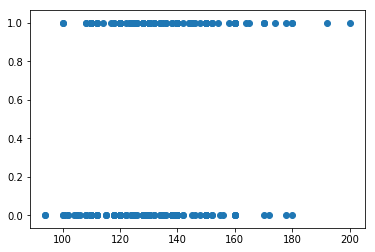

In [44]:
plt.scatter(heart_disease["resting_hr"], heart_disease["binary_labels"])

Can we plot the observed probabilities of the resting heart rate measurements? One problem is that if a particular resting heart rate is observed only once, we just get a 1 for its 'observed probability'. So let's bin our data and look at observed probabilities. 

In [72]:
counts_of_hd = heart_disease.assign(bin=lambda x: pd.cut(x.resting_hr, bins=10)).groupby(['bin'])['binary_labels'].agg(['sum', 'count','mean'])

In [73]:
counts_of_hd

,sum,count,mean
bin,,,
"(93.894, 104.6]",2,10,0.200000
"(104.6, 115.2]",18,42,0.428571
"(115.2, 125.8]",30,67,0.447761
"(125.8, 136.4]",32,74,0.432432
"(136.4, 147.0]",26,56,0.464286
"(147.0, 157.6]",13,27,0.481481
"(157.6, 168.2]",9,14,0.642857
"(168.2, 178.8]",5,8,0.625000
"(178.8, 189.4]",2,3,0.666667


Great: the column "mean" above is giving the observed probability of heart disease (since we marked used an indicator variable for the presence of heart disease). This can be used for our log odds plot.

In [75]:
counts_of_hd["log_odds"] = np.log(counts_of_hd['mean']/(1-counts_of_hd['mean']))
counts_of_hd["log_odds"]

bin
(93.894, 104.6]   -1.386294
(104.6, 115.2]    -0.287682
(115.2, 125.8]    -0.209721
(125.8, 136.4]    -0.271934
(136.4, 147.0]    -0.143101
(147.0, 157.6]    -0.074108
(157.6, 168.2]     0.587787
(168.2, 178.8]     0.510826
(178.8, 189.4]     0.693147
(189.4, 200.0]          inf
Name: log_odds, dtype: float64

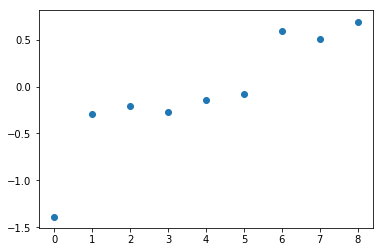

In [80]:
# I'm just plotting against bin number here -- quick and easy.
plt.scatter(x=range(0,10), y=counts_of_hd["log_odds"])

Well, not very linear... but it's an exercise. We'll probably find that logistic regression is not a great model.

Text(0.5, 1.0, 'Log Odds Linear Plot')

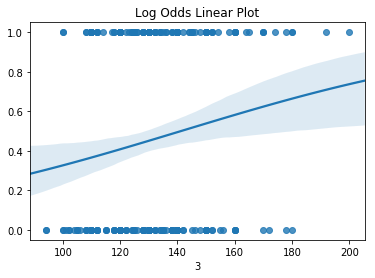

In [31]:
# Here's a nice different kind of plot, for fun.
import seaborn as sns
sns.regplot(x= rest_hr , y= labels, logistic= True).set_title("Log Odds Linear Plot")

Let's go to fitting the logistic regression model using sklearn:

In [90]:
from sklearn.linear_model import LogisticRegression
X = heart_disease["resting_hr"]
y = heart_disease['binary_labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13249)
clf = LogisticRegression(random_state=0).fit(X_train, y_test)

/Users/kaisa/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: Expected 2D array, got 1D array instead:
array=[110. 140. 148. 120.  94. 140. 160. 150. 130. 120. 130. 125. 128. 134.
 132. 138. 160. 130. 123. 170. 120. 132. 178. 150. 130. 165. 120. 102.
 140. 140. 150. 115. 138. 110. 108. 145. 110. 138. 156. 200. 142. 138.
 138. 128. 130. 132. 100. 118. 130. 110. 130. 144. 128. 120. 110. 130.
 120. 146. 130. 140. 130. 134. 112. 148. 145. 126. 110. 125. 100. 130.
 152. 140. 130. 120. 136. 120. 130. 122. 130. 170. 126. 108. 140. 150.
 132. 125. 129. 104. 160. 134. 128. 135. 140. 180. 114. 122. 120. 125.
 110. 150. 130. 120. 128. 120. 138. 130. 150. 120. 152. 110. 170. 125.
 132. 110. 124. 145. 140. 130. 134. 160. 120. 128. 122. 150. 120. 140.
 108. 112. 152. 130. 100. 128. 138. 158. 120. 130. 106. 140. 120. 112.
 150. 140. 140. 140. 120. 136. 130. 138. 120. 152. 120. 122. 135. 112.
 138. 112. 105. 124. 192. 130. 140. 155.  94. 140. 105. 180. 110. 112.
 120. 125. 140. 117. 118. 108. 130. 105. 152. 164. 120. 150. 120. 125.
 130. 120. 135. 118. 132. 115. 100. 112. 101. 160. 160. 112. 130. 130.
 130. 120. 110. 118. 172. 140. 110. 110. 140. 120. 110. 128. 140. 130.
 130. 150. 160. 140. 140. 120. 150. 120. 108. 138. 150. 140. 130. 150.
 145. 128. 180. 140. 140. 130. 110. 135. 124. 142. 110. 150. 120. 120.
 130. 134. 102. 118.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

Oh no, a warning/error! Fortunately the message at the bottom tells us exactly what to do. Make our input an array and reshape it.

In [87]:
X = np.array(heart_disease["resting_hr"]).reshape(-1,1)
y = heart_disease['binary_labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13249)
clf = LogisticRegression(random_state=0).fit(X_train, y_test)
clf = LogisticRegression(random_state=0).fit(X, y)

/Users/kaisa/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[145.],
       [160.],
       [120.],
       [130.],
       [130.],
       [120.],
       [140.],
       [120.],
       [130.],
       [140.],
       [140.],
       [140.],
       [130.],
       [120.],
       [172.],
       [150.],
       [110.],
       [140.],
       [130.],
       [130.],
       [110.],
       [150.],
       [120.],
       [132.],
       [130.],
       [120.],
       [120.],
       [150.],
       [150.],
       [110.],
       [140.],
       [117.],
       [140.],
       [135.],
       [130.],
       [140.],
       [120.],
       [150.],
       [132.],
       [150.],
       [150.],
       [140.],
       [160.],
       [150.],
       [130.],
       [112.],
       [110.],
       [150.],
       [140.],
       [130.],
       [105.],
       [120.],
       [112.],
       [130.],
       [130.],
       [124.],
       [140.],
       [110.],
       [125.],
       [125.],
       [130.],
       [142.],
       [128.],
       [135.],
       [120.],
       [145.],
       [14